# EMA Worry Analysis with medGemma

**© 2024 [Your Name]. All rights reserved.**

This notebook analyzes Ecological Momentary Assessment (EMA) text data to detect worry patterns using medGemma.
The data is expected to be exported from m-path software in CSV format.

**Copyright Notice:** This work is protected by copyright. See COPYRIGHT.md for usage terms.
**Citation Required:** If you use this framework, proper attribution is required.

## Features:
- Load and process m-path EMA data
- Use medGemma to classify worry presence (1) or absence (0)
- Generate analysis reports and visualizations
- Export results for further analysis

## Original Development
- **Created:** December 27, 2024
- **Author:** [Your Name]
- **Framework Version:** 1.0.0

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')

## Configuration
Update these settings according to your setup:

In [12]:
# File paths
DATA_FILE_PATH = 'sample_mpath_ema_data.csv'  # Update with your m-path export file
OUTPUT_FILE_PATH = 'ema_worry_analysis_results.csv'

# Column names (adjust based on your m-path export format)
TEXT_COLUMN = 'response_text'
PARTICIPANT_COLUMN = 'participant_id'
TIMESTAMP_COLUMN = 'timestamp'

# LM Studio API configuration
LM_STUDIO_API_URL = 'http://localhost:1234/v1/chat/completions'  # LM Studio local endpoint
LM_STUDIO_MODEL = 'medgemma-27b-text-it-mlx'  # Model name in LM Studio

# Analysis parameters
BATCH_SIZE = 10  # Process texts in batches
DELAY_BETWEEN_REQUESTS = 2  # Seconds between API calls (LM Studio might need more time)

## Data Loading and Exploration

In [13]:
# Load the EMA data
try:
    df = pd.read_csv(DATA_FILE_PATH)
    print(f"Successfully loaded data from {DATA_FILE_PATH}")
    print(f"Dataset shape: {df.shape}")
    print("\nColumn names:")
    print(df.columns.tolist())
    
    # Check if required columns exist
    required_columns = [TEXT_COLUMN, PARTICIPANT_COLUMN, TIMESTAMP_COLUMN]
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"\nWarning: Missing required columns: {missing_columns}")
        print("Please update the column names in the configuration section.")
    else:
        print("\nAll required columns found!")
        
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE_PATH}")
    print("Please update DATA_FILE_PATH or ensure the file exists.")
except Exception as e:
    print(f"Error loading data: {e}")

Successfully loaded data from sample_mpath_ema_data.csv
Dataset shape: (20, 6)

Column names:
['participant_id', 'timestamp', 'prompt_id', 'prompt_text', 'response_text', 'session_id']

All required columns found!


In [14]:
# Data exploration
if 'df' in locals():
    print("=== Dataset Overview ===")
    print(f"Total responses: {len(df)}")
    print(f"Unique participants: {df[PARTICIPANT_COLUMN].nunique()}")
    print(f"Date range: {df[TIMESTAMP_COLUMN].min()} to {df[TIMESTAMP_COLUMN].max()}")
    
    print("\n=== Sample responses ===")
    for i, row in df.head(3).iterrows():
        print(f"Participant {row[PARTICIPANT_COLUMN]}: {row[TEXT_COLUMN][:100]}...")
    
    print("\n=== Text length statistics ===")
    df['text_length'] = df[TEXT_COLUMN].str.len()
    print(df['text_length'].describe())

=== Dataset Overview ===
Total responses: 20
Unique participants: 6
Date range: 2024-01-15 09:30:00 to 2024-01-18 21:30:00

=== Sample responses ===
Participant P001: I'm feeling quite anxious about my upcoming presentation at work. I keep thinking about all the thin...
Participant P001: Just had lunch but I can't stop worrying about whether I said something wrong to my colleague earlie...
Participant P001: Feeling relaxed now, watching TV with my partner. It's nice to just unwind after a long day....

=== Text length statistics ===
count     20.000000
mean     121.800000
std       18.614086
min       88.000000
25%      107.000000
50%      126.500000
75%      135.000000
max      152.000000
Name: text_length, dtype: float64


## medGemma Integration

This section sets up the connection to medGemma for worry classification.

In [15]:
def classify_worry_with_medgemma(text):
    """
    Classify worry presence in text using medGemma via LM Studio.
    Returns 1 for worry present, 0 for worry absent.
    """
    messages = [
        {
            "role": "system",
            "content": "You are a medical AI assistant specialized in mental health assessment. Your task is to analyze text and determine if it contains expressions of worry, anxiety, or concern. Respond with only '1' if worry/anxiety/concern is present, or '0' if absent."
        },
        {
            "role": "user",
            "content": f"""Analyze the following text and determine if it contains expressions of worry, anxiety, or concern.

Text: "{text}"

Instructions:
- Respond with only "1" if worry/anxiety/concern is present
- Respond with only "0" if no worry/anxiety/concern is detected
- Look for keywords like: worried, anxious, concerned, stressed, nervous, afraid, fear, overthinking
- Consider implicit expressions of worry (e.g., "what if", "I can't stop thinking about")

Response (1 or 0 only):"""
        }
    ]
    
    try:
        payload = {
            "model": LM_STUDIO_MODEL,
            "messages": messages,
            "temperature": 0.1,
            "max_tokens": 10,
            "stream": False
        }
        
        response = requests.post(LM_STUDIO_API_URL, json=payload, timeout=30)
        response.raise_for_status()
        
        result = response.json()
        prediction = result['choices'][0]['message']['content'].strip()
        
        # Parse the response
        if prediction in ['1', '1.0', 'YES', 'yes', 'Yes']:
            return 1
        elif prediction in ['0', '0.0', 'NO', 'no', 'No']:
            return 0
        else:
            # If response is unclear, try to extract number
            if '1' in prediction:
                return 1
            elif '0' in prediction:
                return 0
            else:
                print(f"Warning: Unclear response '{prediction}' for text: {text[:50]}... Defaulting to 0.")
                return 0
                
    except requests.exceptions.RequestException as e:
        print(f"API request failed for text '{text[:50]}...': {e}")
        return 0
    except Exception as e:
        print(f"Error processing text '{text[:50]}...': {e}")
        return 0

def test_lmstudio_connection():
    """
    Test the connection to LM Studio API.
    """
    test_text = "I'm really worried about my exam tomorrow. I can't stop thinking about failing."
    
    print(f"Testing LM Studio connection with: '{test_text}'")
    
    try:
        result = classify_worry_with_medgemma(test_text)
        print(f"Test successful! Worry classification: {result}")
        return True
    except Exception as e:
        print(f"Connection test failed: {e}")
        print("\\nTroubleshooting:")
        print("1. Ensure LM Studio is running with a model loaded")
        print("2. Check that the Local Server is started in LM Studio")
        print("3. Verify the API URL (default: http://localhost:1234/v1/chat/completions)")
        print("4. Make sure medgemma-27b-text-it-mlx is loaded in LM Studio")
        return False

In [16]:
# Test LM Studio connection
connection_success = test_lmstudio_connection()

Testing LM Studio connection with: 'I'm really worried about my exam tomorrow. I can't stop thinking about failing.'
Test successful! Worry classification: 1


## Worry Analysis

Process all text responses through medGemma for worry classification.

In [17]:
if 'df' in locals() and connection_success:
    print(f"Starting worry analysis on {len(df)} text responses...")
    print(f"Processing in batches of {BATCH_SIZE} with {DELAY_BETWEEN_REQUESTS}s delay")
    
    # Initialize results
    worry_scores = []
    processed_count = 0
    
    # Process texts in batches
    for i, text in enumerate(df[TEXT_COLUMN]):
        if pd.isna(text) or text.strip() == '':
            worry_scores.append(0)
        else:
            score = classify_worry_with_medgemma(str(text))
            worry_scores.append(score)
        
        processed_count += 1
        
        # Progress update
        if processed_count % BATCH_SIZE == 0:
            progress = (processed_count / len(df)) * 100
            print(f"Progress: {processed_count}/{len(df)} ({progress:.1f}%)")
            time.sleep(DELAY_BETWEEN_REQUESTS)
    
    # Add results to dataframe
    df['worry_score'] = worry_scores
    
    print(f"\nAnalysis complete! Processed {processed_count} responses.")
    print(f"Worry detected in {sum(worry_scores)} responses ({(sum(worry_scores)/len(worry_scores)*100):.1f}%)")

elif 'df' not in locals():
    print("Please load data first by running the data loading cell.")
elif not connection_success:
    print("Please fix the medGemma connection before proceeding with analysis.")

Starting worry analysis on 20 text responses...
Processing in batches of 10 with 2s delay
Progress: 10/20 (50.0%)
Progress: 20/20 (100.0%)

Analysis complete! Processed 20 responses.
Worry detected in 12 responses (60.0%)


## Results Analysis and Visualization

In [18]:
if 'worry_score' in df.columns:
    print("=== WORRY ANALYSIS SUMMARY ===")
    
    # Overall statistics
    total_responses = len(df)
    worry_responses = df['worry_score'].sum()
    worry_percentage = (worry_responses / total_responses) * 100
    
    print(f"Total responses analyzed: {total_responses}")
    print(f"Responses with worry detected: {worry_responses}")
    print(f"Percentage with worry: {worry_percentage:.1f}%")
    
    # Per-participant analysis
    participant_stats = df.groupby(PARTICIPANT_COLUMN).agg({
        'worry_score': ['count', 'sum', 'mean']
    }).round(2)
    participant_stats.columns = ['Total_Responses', 'Worry_Count', 'Worry_Rate']
    
    print("\n=== PER-PARTICIPANT WORRY RATES ===")
    print(participant_stats)
    
    # Show examples of worry vs non-worry responses
    print("\n=== EXAMPLES OF CLASSIFIED RESPONSES ===")
    
    worry_examples = df[df['worry_score'] == 1][TEXT_COLUMN].head(3)
    no_worry_examples = df[df['worry_score'] == 0][TEXT_COLUMN].head(3)
    
    print("\nWorry detected (score = 1):")
    for i, text in enumerate(worry_examples, 1):
        print(f"{i}. {text}")
    
    print("\nNo worry detected (score = 0):")
    for i, text in enumerate(no_worry_examples, 1):
        print(f"{i}. {text}")

=== WORRY ANALYSIS SUMMARY ===
Total responses analyzed: 20
Responses with worry detected: 12
Percentage with worry: 60.0%

=== PER-PARTICIPANT WORRY RATES ===
                Total_Responses  Worry_Count  Worry_Rate
participant_id                                          
P001                          5            4        0.80
P002                          4            2        0.50
P003                          4            1        0.25
P004                          3            3        1.00
P005                          2            0        0.00
P006                          2            2        1.00

=== EXAMPLES OF CLASSIFIED RESPONSES ===

Worry detected (score = 1):
1. I'm feeling quite anxious about my upcoming presentation at work. I keep thinking about all the things that could go wrong.
2. Just had lunch but I can't stop worrying about whether I said something wrong to my colleague earlier. My mind keeps replaying the conversation.
3. Concerned about my mom's health. Sh

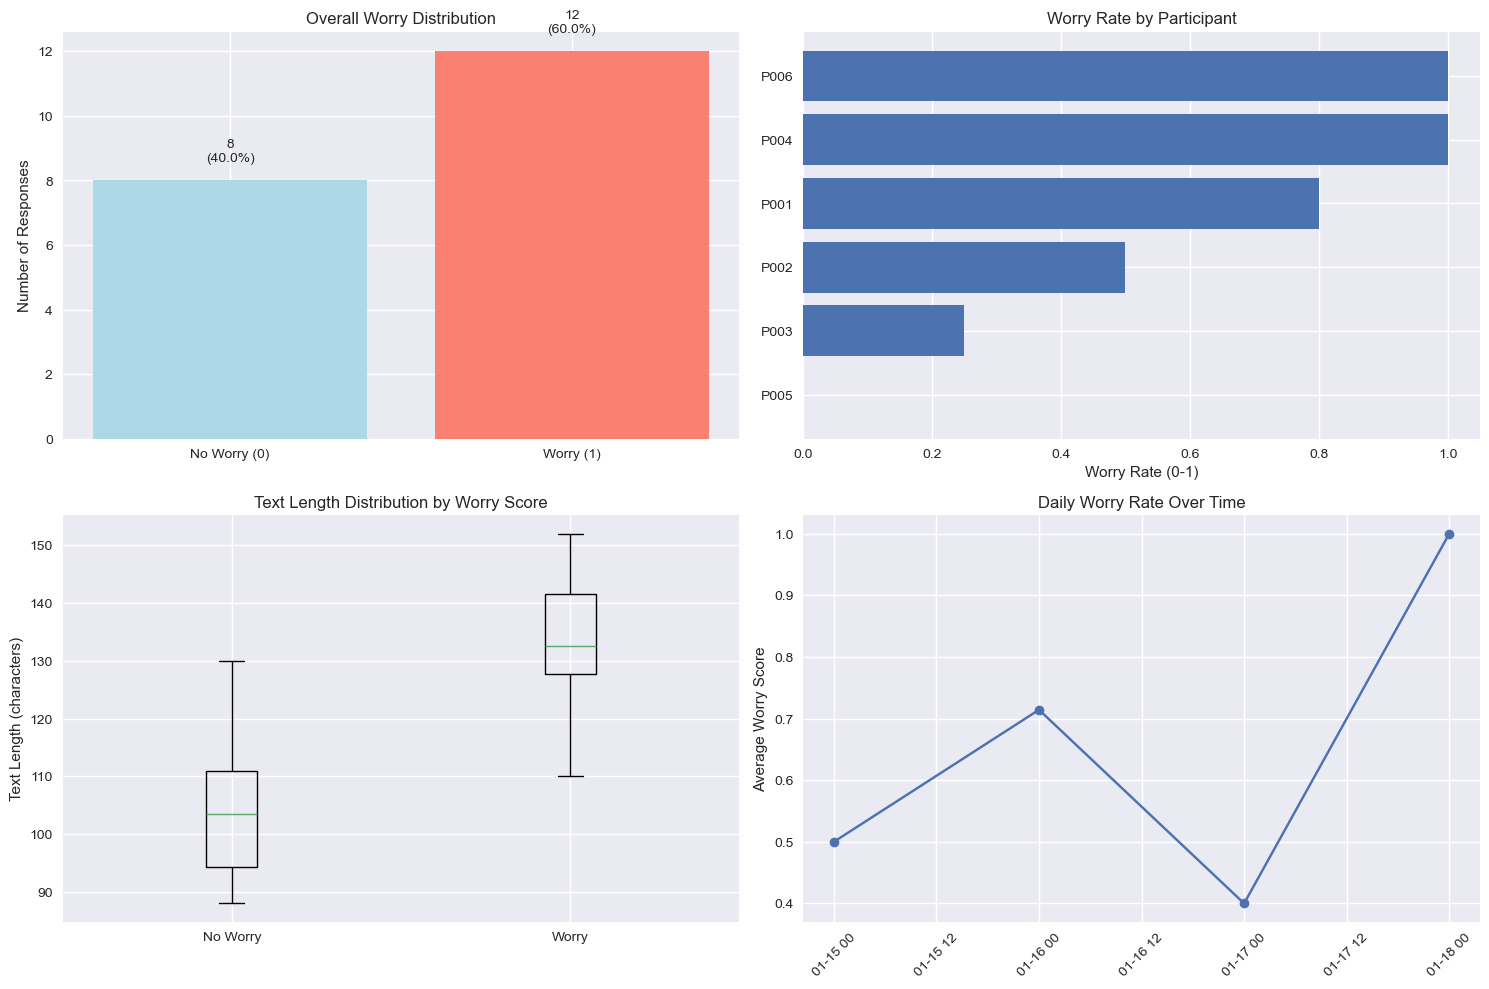


Visualization saved as 'ema_worry_analysis_plots.png'


<Figure size 800x550 with 0 Axes>

In [19]:
if 'worry_score' in df.columns:
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Overall worry distribution
    worry_counts = df['worry_score'].value_counts().sort_index()
    axes[0, 0].bar(['No Worry (0)', 'Worry (1)'], worry_counts.values, 
                   color=['lightblue', 'salmon'])
    axes[0, 0].set_title('Overall Worry Distribution')
    axes[0, 0].set_ylabel('Number of Responses')
    
    # Add percentages on bars
    for i, v in enumerate(worry_counts.values):
        pct = (v / total_responses) * 100
        axes[0, 0].text(i, v + 0.5, f'{v}\n({pct:.1f}%)', 
                       ha='center', va='bottom')
    
    # 2. Worry rates by participant
    participant_worry_rates = participant_stats['Worry_Rate'].sort_values(ascending=True)
    axes[0, 1].barh(range(len(participant_worry_rates)), participant_worry_rates.values)
    axes[0, 1].set_yticks(range(len(participant_worry_rates)))
    axes[0, 1].set_yticklabels(participant_worry_rates.index)
    axes[0, 1].set_title('Worry Rate by Participant')
    axes[0, 1].set_xlabel('Worry Rate (0-1)')
    
    # 3. Text length vs worry
    worry_texts = df[df['worry_score'] == 1]['text_length']
    no_worry_texts = df[df['worry_score'] == 0]['text_length']
    
    axes[1, 0].boxplot([no_worry_texts, worry_texts], 
                       labels=['No Worry', 'Worry'])
    axes[1, 0].set_title('Text Length Distribution by Worry Score')
    axes[1, 0].set_ylabel('Text Length (characters)')
    
    # 4. Timeline analysis (if timestamp is available)
    try:
        df['timestamp_parsed'] = pd.to_datetime(df[TIMESTAMP_COLUMN])
        df['date'] = df['timestamp_parsed'].dt.date
        
        daily_worry = df.groupby('date')['worry_score'].mean()
        axes[1, 1].plot(daily_worry.index, daily_worry.values, marker='o')
        axes[1, 1].set_title('Daily Worry Rate Over Time')
        axes[1, 1].set_ylabel('Average Worry Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'Timeline analysis unavailable\n{str(e)}', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Timeline Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plt.savefig('ema_worry_analysis_plots.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as 'ema_worry_analysis_plots.png'")

## Export Results

In [20]:
if 'worry_score' in df.columns:
    # Prepare export dataframe
    export_df = df[[PARTICIPANT_COLUMN, TIMESTAMP_COLUMN, TEXT_COLUMN, 'worry_score', 'text_length']].copy()
    export_df.columns = ['participant_id', 'timestamp', 'text_response', 'worry_score', 'text_length']
    
    # Add analysis metadata
    export_df['analysis_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    export_df['model_used'] = LM_STUDIO_MODEL
    
    # Save to CSV
    export_df.to_csv(OUTPUT_FILE_PATH, index=False)
    print(f"Results exported to: {OUTPUT_FILE_PATH}")
    
    # Create summary report
    summary_report = f"""EMA WORRY ANALYSIS REPORT
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Model: {LM_STUDIO_MODEL}

DATASET SUMMARY:
- Total responses: {total_responses}
- Unique participants: {df[PARTICIPANT_COLUMN].nunique()}
- Responses with worry: {worry_responses} ({worry_percentage:.1f}%)
- Average text length: {df['text_length'].mean():.1f} characters

PER-PARTICIPANT STATISTICS:
{participant_stats.to_string()}

FILES GENERATED:
- Detailed results: {OUTPUT_FILE_PATH}
- Visualizations: ema_worry_analysis_plots.png
- Summary report: ema_worry_analysis_report.txt
"""
    
    with open('ema_worry_analysis_report.txt', 'w') as f:
        f.write(summary_report)
    
    print("Summary report saved as: ema_worry_analysis_report.txt")
    print("\\n=== ANALYSIS COMPLETE ===")
    print(f"Check the following files for results:")
    print(f"- {OUTPUT_FILE_PATH} (detailed data)")
    print(f"- ema_worry_analysis_plots.png (visualizations)")
    print(f"- ema_worry_analysis_report.txt (summary report)")

else:
    print("No analysis results to export. Please run the worry analysis first.")

Results exported to: ema_worry_analysis_results.csv
Summary report saved as: ema_worry_analysis_report.txt
\n=== ANALYSIS COMPLETE ===
Check the following files for results:
- ema_worry_analysis_results.csv (detailed data)
- ema_worry_analysis_plots.png (visualizations)
- ema_worry_analysis_report.txt (summary report)


## Troubleshooting & Notes

### Common Issues:

1. **LM Studio Connection Failed**
   - Ensure LM Studio is running with Local Server started
   - Check that medgemma-27b-text-it-mlx model is loaded
   - Verify API URL: `http://localhost:1234/v1/chat/completions`
   - Test connection: Go to LM Studio → Local Server tab → ensure server is running

2. **Model Loading Issues**
   - Download medgemma-27b-text-it-mlx in LM Studio's Discover tab
   - Ensure model is selected in the Local Server tab
   - Check available system memory (model requires significant RAM)

3. **Data Loading Issues**
   - Verify file path is correct
   - Check column names match your m-path export
   - Ensure CSV file is properly formatted

4. **Analysis Performance**
   - Adjust BATCH_SIZE and DELAY_BETWEEN_REQUESTS
   - For large datasets, consider processing in chunks
   - Increase delay if getting timeout errors
   - Close other applications to free up system resources

5. **API Response Issues**
   - Check LM Studio logs for error messages
   - Ensure model has sufficient context length
   - Try restarting LM Studio if responses are inconsistent

### LM Studio Configuration:
- **Port**: Default 1234 (update notebook if different)
- **Model**: Use medgemma-27b-text-it-mlx for best medical analysis
- **Context Length**: Set to at least 4096 tokens
- **Temperature**: 0.1 for consistent results

### Data Format Notes:
- This notebook expects CSV format from m-path export
- Required columns: participant_id, timestamp, response_text
- Text responses should contain the participant's written responses

### Model Performance:
- medGemma is optimized for medical/mental health text analysis
- Results are binary: 1 (worry present) or 0 (worry absent)
- Consider manual validation of a sample for quality assurance
- If using alternative models, adjust prompts accordingly